In [26]:
# -*- coding: utf-8 -*-
"""
Created on 2023-10-10

@author: ivespe

Intro script for Exercise 4 ("Battery energy storage system in the grid vs. grid investments") 
in specialization course module "Flexibility in power grid operation and planning" 
at NTNU (TET4565/TET4575) 

"""


# %% Dependencies

import pandas as pd
import os
import load_profiles as lp
import pandapower_read_csv as ppcsv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# %% Define input data

# Location of (processed) data set for CINELDI MV reference system
# (to be replaced by your own local data folder)
path_data_set         = 'C:/Users/benny/Downloads/Cineldi/Data'

filename_load_data_fullpath = os.path.join(path_data_set,'load_data_CINELDI_MV_reference_system.csv')
filename_load_mapping_fullpath = os.path.join(path_data_set,'mapping_loads_to_CINELDI_MV_reference_grid.csv')
filename_standard_overhead_lines = os.path.join(path_data_set,'standard_overhead_line_types.csv')
filename_reldata = os.path.join(path_data_set,'reldata_for_component_types.csv')
filename_load_point = os.path.join(path_data_set,'CINELDI_MV_reference_system_load_point.csv')

# Subset of load buses to consider in the grid area, considering the area at the end of the main radial in the grid
bus_i_subset = [90, 91, 92, 96]

# Assumed power flow limit in MW that limit the load demand in the grid area (through line 85-86)
P_lim = 4

# Factor to scale the loads for this exercise compared with the base version of the CINELDI reference system data set
scaling_factor = 10

# Read standard data for overhead lines
data_standard_overhead_lines = pd.read_csv(filename_standard_overhead_lines, delimiter=';')
data_standard_overhead_lines.set_index(keys = 'type', drop = True, inplace = True)

# Read standard component reliability data
data_comp_rel = pd.read_csv(filename_reldata, delimiter=';')
data_comp_rel.set_index(keys = 'main_type', drop = True, inplace = True)

# Read load point data (incl. specific rates of costs of energy not supplied) for data
data_load_point = pd.read_csv(filename_load_point, delimiter=';')
data_load_point.set_index(keys = 'bus_i', drop = True, inplace = True)


# %% Read pandapower network

net = ppcsv.read_net_from_csv(path_data_set, baseMVA=10)


# %% Set up hourly normalized load time series for a representative day (task 2; this code is provided to the students)

load_profiles = lp.load_profiles(filename_load_data_fullpath)

# Consider only the day with the peak load in the area (28 February)
repr_days = [31+28]

# Get relative load profiles for representative days mapped to buses of the CINELDI test network;
# the column index is the bus number (1-indexed) and the row index is the hour of the year (0-indexed)
profiles_mapped = load_profiles.map_rel_load_profiles(filename_load_mapping_fullpath,repr_days)

# Calculate load time series in units MW (or, equivalently, MWh/h) by scaling the normalized load time series by the
# maximum load value for each of the load points in the grid data set (in units MW); the column index is the bus number
# (1-indexed) and the row index is the hour of the year (0-indexed)
load_time_series_mapped = profiles_mapped.mul(net.load['p_mw'])


# %% Aggregate the load demand in the area

# Aggregated load time series for the subset of load buses
load_time_series_subset = load_time_series_mapped[bus_i_subset] * scaling_factor
load_time_series_subset_aggr = load_time_series_subset.sum(axis=1)

P_max = load_time_series_subset_aggr.max()


c:\Users\benny\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


## Task 2

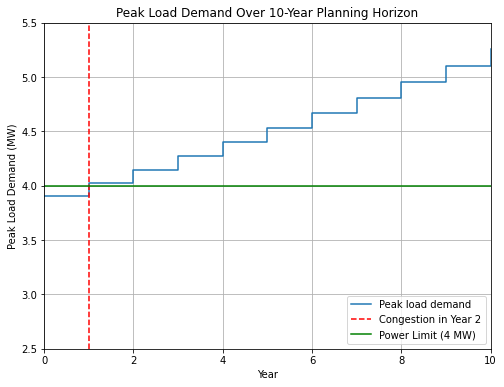

Congestion occurs in Year 2, at which point measures need to be implemented.


In [27]:
import matplotlib.pyplot as plt

# Initialize lists to store the results
years = []
peak_loads = []

# Iterate through the 10-year planning horizon
for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1+ 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = load_time_series_subset * yearly_scaling_factor
    
    # Calculate the peak load demand for this year
    peak_load = scaled_load_time_series.sum(axis=1).max()

    # Append the year and peak load to the lists
    years.append(year)
    peak_loads.append(peak_load)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(years, peak_loads, linestyle='-', label="Peak load demand", drawstyle="steps-post")
plt.xlabel("Year")
plt.ylabel("Peak Load Demand (MW)")
plt.title("Peak Load Demand Over 10-Year Planning Horizon")
plt.grid(True)

# Identify the year when congestion occurs
congestion_year = np.where(np.array(peak_loads) > P_lim)[0][0]
plt.axvline(congestion_year, color='red', linestyle='--', label=f"Congestion in Year {congestion_year+1}")
plt.axhline(P_lim, color='green', linestyle='-', label="Power Limit (4 MW)")


plt.xlim(0, 10)
plt.ylim(2.5, 5.5)

plt.legend()
plt.show()

print(f"Congestion occurs in Year {congestion_year+1}, at which point measures need to be implemented.")


## Task 3

In [28]:
l = 20  #km

# Assuming no residual value or decommissioning costs for the old line,
cost_new_line = 759408*l



print(f"Investment cost of the new line (FeAl 70): {cost_new_line} NOK per kilometer")

Investment cost of the new line (FeAl 70): 15188160 NOK per kilometer


## Task 4

In [29]:
# Define the discount rate and the number of years into the future
discount_rate = 0.04  # 4% as a decimal
years_into_future = 1  # Since we're calculating the present value at the beginning of year 2 = end of year 1

# Calculate the present value
def PresentValue(cost,discount_rate,years):
    return cost / (1 + discount_rate) ** years


present_value = PresentValue(cost_new_line,discount_rate,years_into_future)


# Display the present value
print(f"Present value of the investment costs: {present_value:.2f} NOK per kilometer")


Present value of the investment costs: 14604000.00 NOK per kilometer


## Task 5

In [30]:
# Define the economic lifetime of the new line (in years)
economic_lifetime = 40

# Define the number of years into the future (20 years analysis horizon)
years_into_future = 20

# Calculate the residual value of the new line after 20 years
# The residual value is the remaining economic life, expressed as a fraction of the initial investment cost.
residual_value = (economic_lifetime - years_into_future) / economic_lifetime * cost_new_line

# Calculate the present value of the residual value
present_value_residual_value = PresentValue(residual_value,discount_rate,years_into_future)
present_value_investment     = PresentValue(cost_new_line,discount_rate,years_into_future)



# Calculate the present value of the investment cost corrected for the residual value
present_value_corrected = present_value_investment - present_value_residual_value

# Display the results
print(f"Residual value of the new line after 20 years: {residual_value:.2f} NOK")
print(f"Present value of the residual value: {present_value_residual_value:.2f} NOK")
print(f"Present value of the investment: {present_value_investment:.2f} NOK")
print(f"Present value of the investment cost corrected for the residual value: {present_value_corrected:.2f} NOK")


Residual value of the new line after 20 years: 7594080.00 NOK
Present value of the residual value: 3465838.98 NOK
Present value of the investment: 6931677.96 NOK
Present value of the investment cost corrected for the residual value: 3465838.98 NOK


## Task 6

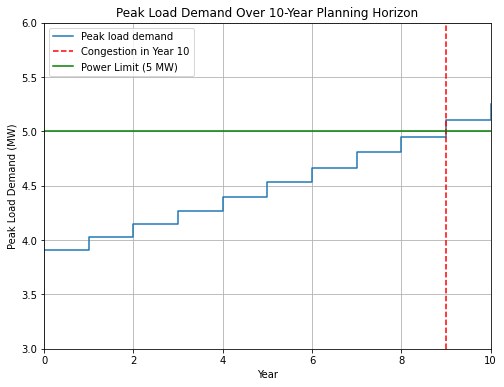

Congestion occurs in Year 10, at which point measures need to be implemented.


In [31]:
import matplotlib.pyplot as plt

# Initialize lists to store the results
years = []
peak_loads = []

congestion_year = None
battery_power_capacity = 1  # MW
battery_energy_capacity = 2  # MWh
investment_costs = []  # To store present value of grid investments
new_plim = P_lim + battery_power_capacity       #Use the battery power capacity to shit the load limit

# Iterate through the 10-year planning horizon
for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1+ 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = load_time_series_subset * yearly_scaling_factor
    
    # Calculate the peak load demand for this year
    peak_load = scaled_load_time_series.sum(axis=1).max() #- battery_power_capacity

    # Append the year and peak load to the lists
    years.append(year)
    peak_loads.append(peak_load)


#transparent_peak_loads = [peak_load + battery_power_capacity for peak_load in peak_loads]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(years, peak_loads, linestyle='-', label="Peak load demand", drawstyle="steps-post")
#plt.plot(years, transparent_peak_loads, linestyle='--', alpha=0.4, color='blue', label="Peak load demand (without battery)",drawstyle="steps-post")
plt.xlabel("Year")
plt.ylabel("Peak Load Demand (MW)")
plt.title("Peak Load Demand Over 10-Year Planning Horizon")
plt.grid(True)

# Identify the year when congestion occurs
congestion_year = np.where(np.array(peak_loads) > new_plim)[0][0]
plt.axvline(congestion_year, color='red', linestyle='--', label=f"Congestion in Year {congestion_year+1}")
plt.axhline(new_plim, color='green', linestyle='-', label="Power Limit (5 MW)")


plt.xlim(0, 10)
plt.ylim(3, 6)

plt.legend()
plt.show()

print(f"Congestion occurs in Year {congestion_year+1}, at which point measures need to be implemented.")

In [32]:
##Recalculating the present value of grid investments now that the year is changed from 1 to 9

# Define the discount rate and the number of years into the future
discount_rate = 0.04  # 4% as a decimal
years_into_future = 9  # Since we're calculating the present value at the beginning of year 10 = end of year 9

# Calculate the present value
def PresentValue(cost,discount_rate,years):
    return cost / (1 + discount_rate) ** years


present_value = PresentValue(cost_new_line,discount_rate,years_into_future)


# Display the present value
print(f"Present value of the investment costs: {present_value:.2f} NOK per kilometer")

# Define the economic lifetime of the new line (in years)
economic_lifetime = 40

# Define the number of years into the future (20 years analysis horizon)
years_into_future = 20

# Calculate the residual value of the new line after 20 years
# The residual value is the remaining economic life, expressed as a fraction of the initial investment cost.
residual_value = (economic_lifetime - years_into_future) / economic_lifetime * cost_new_line

# Calculate the present value of the residual value
present_value_residual_value = PresentValue(residual_value,discount_rate,years_into_future)
present_value_investment     = PresentValue(cost_new_line,discount_rate,years_into_future)



# Calculate the present value of the investment cost corrected for the residual value
present_value_corrected = present_value_investment - present_value_residual_value

# Display the results
print(f"Residual value of the new line after 20 years: {residual_value:.2f} NOK")
print(f"Present value of the residual value: {present_value_residual_value:.2f} NOK")
print(f"Present value of the investment: {present_value_investment:.2f} NOK")
print(f"Present value of the investment cost corrected for the residual value: {present_value_corrected:.2f} NOK")


Present value of the investment costs: 10670999.75 NOK per kilometer
Residual value of the new line after 20 years: 7594080.00 NOK
Present value of the residual value: 3465838.98 NOK
Present value of the investment: 6931677.96 NOK
Present value of the investment cost corrected for the residual value: 3465838.98 NOK


## Task 7

In [82]:
exceeding_power = []
total_exceeding_power = []

p_MWH = 2000
days = 20
daily = load_time_series_subset_aggr

for year in range(10):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1+ 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = load_time_series_subset_aggr * yearly_scaling_factor

    # Initialize a variable to store the sum of exceeding power for this year
    yearly_exceeding_power = 0

    for i in scaled_load_time_series:
        if i > P_lim:
            exceeding_power_amount = i - P_lim
            exceeding_power.append(exceeding_power_amount)
            yearly_exceeding_power += exceeding_power_amount

    # Append the total exceeding power for this year to the list
    total_exceeding_power.append(yearly_exceeding_power)
        
ACT_costs_B = []    
for year in range(10): 
    costs = total_exceeding_power[year] * days * p_MWH
    ACT_costs_B.append(costs)
    print(f"Costs for exceeding power amount of", exceeding_power[year] ,"in year", year+1, "was equal to:",ACT_costs_B[year])


Costs for exceeding power amount of 0.026135131932091937 in year 1 was equal to: 0
Costs for exceeding power amount of 0.03797452818325997 in year 2 was equal to: 1045.4052772836776
Costs for exceeding power amount of 0.14691918589005404 in year 3 was equal to: 7395.74856293256
Costs for exceeding power amount of 0.04654871785317116 in year 4 was equal to: 21593.522559185487
Costs for exceeding power amount of 0.1591137640287581 in year 5 was equal to: 47181.390582101805
Costs for exceeding power amount of 0.2713267614667556 in year 6 was equal to: 89221.71874141892
Costs for exceeding power amount of 0.06284882063095232 in year 7 was equal to: 145181.76827055635
Costs for exceeding power amount of 0.16794517938876652 in year 8 was equal to: 217099.29819394523
Costs for exceeding power amount of 0.28388717694962207 in year 9 was equal to: 301749.72731219965
Costs for exceeding power amount of 0.39946656431075933 in year 10 was equal to: 396044.1485092193


## Task 8

In [34]:
import numpy as np

# Given data
line_length = 20  # Length of the feeder in km
average_load_demand_year_1 = 1.841  # MW
years = 11  # Planning horizon

# Retrieve the failure rates from the DataFrame
line_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']             # Frequency of failures per 100km each year
line_fail = line_failure_rate * line_length / (100)                                         # Failures per year over a 20km line
print(f"Failures per year: {line_fail:.2f}")

line_failure_duration = data_comp_rel.loc['Overhead line (1–22 kV)', 'r_perm']              # Hours per failure
print(f"Hours per failure: {line_failure_duration:.2f}")

ENS_A = []

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1 + 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = average_load_demand_year_1 * yearly_scaling_factor

    energy_not_supplied = scaled_load_time_series * line_fail * line_failure_duration  #(demand (MW) * failure rate (%) * duration (h))

    ENS_A.append(energy_not_supplied) 

print(ENS_A)



Failures per year: 0.79
Hours per failure: 3.00
[4.385262, 4.516819860000001, 4.6523244558000005, 4.791894189473999, 4.9356510151582205, 5.083720545612967, 5.2362321619813565, 5.3933191268407965, 5.555118700646022, 5.721772261665403, 5.893425429515364]


## Task 9

In [84]:
import numpy as np

# Given data
line_length = 20  # Length of the feeder in km
P_avg = 1.841  # MW
#years = 11  # Planning horizon

# Retrieve the failure rates from the DataFrame
line_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']             # Frequency of failures per 100km each year
line_fail = line_failure_rate * line_length / (100)                                         # Failures per year over a 20km line
print(f"Failures per year: {line_fail:.2f}")

line_failure_duration = data_comp_rel.loc['Overhead line (1–22 kV)', 'r_perm']              # Hours per failure
print(f"Hours per failure: {line_failure_duration:.2f}")

#Use 4h because it's closest to the failure duration from previous tasks
CENS_90 = data_load_point.loc[90,'c_NOK_per_kWh_4h']
CENS_91 = data_load_point.loc[91,'c_NOK_per_kWh_4h'] 
CENS_92 = data_load_point.loc[92,'c_NOK_per_kWh_4h']
CENS_96 = data_load_point.loc[96,'c_NOK_per_kWh_4h']

CENS_avg = ((CENS_90 + CENS_91 + CENS_92 + CENS_96)/4)*1000  #Nok per kWh --> nok per mwh
#print(CENS_avg)

ENS_A = []
CENS_A = []

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1 + 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = P_avg * yearly_scaling_factor

    energy_not_supplied = scaled_load_time_series * line_fail * line_failure_duration  #(demand (MWh) * failure rate (%) * duration (h))

    costs_energy_not_supplied = energy_not_supplied * CENS_avg

    ENS_A.append(energy_not_supplied) 
    CENS_A.append(costs_energy_not_supplied)

print(CENS_A)

Failures per year: 0.79
Hours per failure: 3.00
[239665.2191056423, 246855.17567881162, 254260.83094917593, 261888.65587765115, 269745.31555398076, 277837.67502060015, 286172.8052712182, 294757.9894293547, 303600.7291122354, 312708.7509856025, 322090.01351517055]


## Task 10

In [36]:
import numpy as np

# Given data
line_length = 20  # Length of the feeder in km
P_avg = 1.841  # MW (average load demand in grid area)
years = 11  # Planning horizon

#Remember that the battery has a energy storage of 2 MWh, and a capacity of 1 MW


# Retrieve the failure rates from the DataFrame
line_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']             # Frequency of failures per 100km each year
line_fail = line_failure_rate * line_length / (100)                                         # Failures per year over a 20km line
print(f"Failures per year: {line_fail:.2f}")

line_failure_duration = data_comp_rel.loc['Overhead line (1–22 kV)', 'r_perm']              # Hours per failure
print(f"Hours per failure: {line_failure_duration:.2f}")

#Use 4h because it's closest to the failure duration from previous tasks
CENS_90 = data_load_point.loc[90,'c_NOK_per_kWh_4h']
CENS_91 = data_load_point.loc[91,'c_NOK_per_kWh_4h'] 
CENS_92 = data_load_point.loc[92,'c_NOK_per_kWh_4h']
CENS_96 = data_load_point.loc[96,'c_NOK_per_kWh_4h']

CENS_avg = ((CENS_90 + CENS_91 + CENS_92 + CENS_96)/4)*1000  #Nok per kWh --> nok per mwh

ENS_B = []
CENS_B = []

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1 + 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = P_avg * yearly_scaling_factor

    energy_not_supplied = (scaled_load_time_series * line_fail * line_failure_duration - battery_energy_capacity) #(demand (MW) * failure rate (%) * duration (h) - battery_energy_capacity (MWh))

    costs_energy_not_supplied = energy_not_supplied * CENS_avg

    ENS_B.append(energy_not_supplied) 
    CENS_B.append(costs_energy_not_supplied)

Failures per year: 0.79
Hours per failure: 3.00
[2.385262, 2.516819860000001, 2.6523244558000005, 2.7918941894739993, 2.9356510151582205, 3.083720545612967, 3.2362321619813565, 3.3933191268407965, 3.5551187006460223, 3.7217722616654028, 3.8934254295153643]
[130360.36155977967, 137550.318132949, 144955.9734033133, 152583.79833178854, 160440.45800811812, 168532.81747473753, 176867.9477253556, 185453.13188349208, 194295.87156637284, 203403.89343973988, 212785.15596930793]


## Task 12 - NPV for grid solution A

In [37]:
#Calculating NPV
 



Present_value_CENS_A = []
Present_value_ACT_A = []
Present_value_INV_A = []


#Calculating NPV for the grid investment in terms of interruption costs i
for i in range(10):
    #Present_value_INV_A.append(PresentValue(INV_A[i],0.04,i))           #Present value of all time periods for investment costs in grid solution A
    Present_value_ACT_A.append(PresentValue(0,0.04,i))                  #Present value of all time periods for action costs in grid solution A  = 0 since no battery is present
    Present_value_CENS_A.append(PresentValue(CENS_A[i],0.04,i))           #Present value for all interruption costs in grid solution A
    

#print("The NPV of investment costs in grid solution A is:",sum(Present_value_INV_A),"NOK")
print("The NPV of activation costs in grid solution A is:",sum(Present_value_ACT_A),"NOK")
print("The NPV of interruption costs in grid solution A is:",sum(Present_value_CENS_A),"NOK")





The NPV of activation costs in grid solution A is: 0.0 NOK
The NPV of interruption costs in grid solution A is: 2295565.671170287 NOK


## Task 13 - NPV for grid solution B

In [38]:
Present_value_CENS_B = []
Present_value_ACT_B = []
Present_value_INV_B = []


#Calculating NPV for the grid investment in terms of interruption costs i
for i in range(10):
    #Present_value_INV_A.append(PresentValue(INV_B[i],0.04,i))           #Present value of all time periods for investment costs in grid solution A
    Present_value_ACT_B.append(PresentValue(ACT_costs_B[i],0.04,i))                  #Present value of all time periods for action costs in grid solution A  = 0 since no battery is present
    Present_value_CENS_B.append(PresentValue(CENS_B[i],0.04,i))           #Present value for all interruption costs in grid solution A
    

#print("The NPV of investment costs in grid solution A is:",sum(Present_value_INV_B),"NOK")
print("The NPV of activation costs in grid solution B is:",sum(Present_value_ACT_B),"NOK")
print("The NPV of interruption costs in grid solution B is:",sum(Present_value_CENS_B),"NOK")




The NPV of activation costs in grid solution B is: 151592.15057173796 NOK
The NPV of interruption costs in grid solution B is: 1373542.951129278 NOK


## Task 14 - Technical performance of battery from assignment 3

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo # Correct the import here
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.opt import SolverFactory
from pyomo.core import Var, Objective, Constraint
from pyomo.environ import ConstraintList
import time

In [40]:
#Read battery specification 
parametersinput = pd.read_csv('./battery_data.csv', index_col=0)
parameters = parametersinput.loc[1]

#Battery Specification [Constants]
capacity=                2 #Mwh parameters['Battery_Capacity']
charging_power_limit=    1 #parameters["Battery_Power"]
discharging_power_limit= 1 #parameters["Battery_Power"]
charging_efficiency=parameters["Battery_Charge_Efficiency"]
discharging_efficiency=parameters["Battery_Discharge_Efficiency"]

# Read load and PV profile data
testData = pd.read_csv('./profile_input.csv')

# Convert the various timeseries/profiles to numpy arrays
yearly_scaling_factor = (1+0.03)**5 #To represent year 6 (y=5) in the 10 year planning horizon from the load growth
load1 = [x * yearly_scaling_factor for x in load_time_series_subset.sum(axis=1).tolist()] #load#testData['Base_Load'].values#
print(load1)
PV1 = testData['PV'].values
sellPrice = testData['Feed_Price'].values
buyPrice = testData['Load_Price'].values


def array_to_dict(arr):
    if not isinstance(arr, (list, np.ndarray)):
        raise ValueError("Input must be a list or NumPy array")
    
    result_dict = {}
    for idx, value in enumerate(arr):
        result_dict[idx + 1] = value
    
    return result_dict

PV1 = array_to_dict(PV1)
load1 = array_to_dict(load1)
sellPrice = array_to_dict(sellPrice)
buyPrice = array_to_dict(buyPrice)

[3.387570361454695, 3.2662084987345175, 3.293047060011412, 3.2294705657954963, 3.116528594508777, 3.3583458579743524, 3.691165546665268, 3.882616213107844, 4.093822412534881, 4.292983534770429, 4.41240379225811, 4.5314505612400815, 4.310276313807378, 4.220825884595358, 4.075097145365366, 3.8213855528962153, 4.027401018108016, 3.779716047412034, 3.8325720554516605, 3.9884995425370526, 4.0993015850380905, 4.166980720817762, 3.9067285634555375, 3.6348433686994737]


In [41]:
#Environment
model = pyo.ConcreteModel()

#Sets
model.periods = pyo.Set(initialize=range(1,25,1))   #indexed by "t" for time step
#loads_data = {t: load1[t-1] for t in model.periods}
#Parameters
model.loads = pyo.Param(model.periods, initialize=load1)     #load demand
model.sellP = pyo.Param(model.periods,initialize=sellPrice)  #price to discharge
model.buyP = pyo.Param(model.periods,initialize=buyPrice)    #price to charge
model.PV = pyo.Param(model.periods,initialize=0)           #determinsitic solar power production
model.SOC_0 = pyo.Param(model.periods,initialize=0)   #initial state of charge of battery
model.penalty_cost = pyo.Param(model.periods,initialize=10)  #penalty for not covering load demand (arbitrary, used as slack variable)

#Variables:
model.charge = pyo.Var(model.periods, bounds=(0, charging_power_limit))     #assuming no discharge in first hour
model.disch = pyo.Var(model.periods, bounds=(0, discharging_power_limit))   #assuming full discahrge to meet load in first hour
model.grid = pyo.Var(model.periods, within=NonNegativeReals)        #power bought from market
model.charge_PV = pyo.Var(model.periods, within=NonNegativeReals)   #Charge from PV 
model.charge_grid = pyo.Var(model.periods, within=NonNegativeReals) #Charge bought from grid
model.disch_grid = pyo.Var(model.periods, within=NonNegativeReals)  #Discharged power to grid
model.disch_load = pyo.Var(model.periods, within=NonNegativeReals)  #Discharged power to load
model.PV_load = pyo.Var(model.periods, within=NonNegativeReals)     #PV power to load 
model.PV_grid  = pyo.Var(model.periods, within=NonNegativeReals)    #PV power sold to grid           


#Constraints
def charge_rule(model, t):
    return (model.charge_PV[t]+ model.charge_grid[t])*charging_efficiency  == model.charge[t]
model.charge_constraint = pyo.Constraint(model.periods, rule=charge_rule)

def disch_rule(model,t):
    return (model.disch_grid[t] + model.disch_load[t])/discharging_efficiency == model.disch[t] 
model.disch_constraint = pyo.Constraint(model.periods, rule=disch_rule)

def PV_rule(model,t):
    return model.PV_load[t] + model.PV_grid[t] + model.charge_PV[t] == model.PV[t]
    #return model.PV_load[t] + model.PV_grid[t]  == model.PV[t]
model.PV_constraint = pyo.Constraint(model.periods, rule=PV_rule)

def load_rule(model, t):
    return model.PV_load[t] + model.disch_load[t]+ model.grid[t] == model.loads[t]
    #return model.PV_load[t] + model.grid[t] == model.loads[t]
model.load_constraint = pyo.Constraint(model.periods, rule=load_rule)

def SOC_limit(model, t):
    return (0,capacity)
model.SOC = pyo.Var(model.periods,bounds=SOC_limit)

#NEW CONSTRAINT LIMITING NET POWER IMPORT FORM THE GRID TO THE SYSTEM SPECIFIC FOR TASK 4
def grid_rule(model,t):
    return model.grid[t] + model.charge_grid[t] - model.PV_grid[t] - model.disch_grid[t] <= P_lim
model.grid_constraint = pyo.Constraint(model.periods, rule=grid_rule)

#def SOC_end(model,t):
#    tolerance = 1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
#    return model.SOC[t, max(model.periods)] >= capacity - tolerance

def state_of_charge(model, t):  
    if t == 1:
        return model.SOC[t] == model.SOC_0[t] + model.charge_PV[t] + model.charge_grid[t] - (model.disch_grid[t] + model.disch_load[t])
    elif 1<t<24:  
        return model.SOC[t] == model.SOC[t-1] + model.charge_PV[t] + model.charge_grid[t] - (model.disch_grid[t] + model.disch_load[t])
    else:
        return model.SOC[t] - (model.SOC[t-1]  + model.charge_PV[t] + model.charge_grid[t] - (model.disch_grid[t] + model.disch_load[t]))==0
model.state_of_charge_constraint = pyo.Constraint(model.periods, rule=state_of_charge)

#Objective function to minimize costs
def objective_rule(model):
    return sum((model.charge_grid[t] + model.grid[t])*model.buyP[t] for t in model.periods) - sum((model.PV_grid[t] + model.disch_grid[t])*model.sellP[t] for t in model.periods)
    #return sum(( model.grid[t])*model.buyP[t] for t in model.periods) - sum((model.PV_grid[t])*model.sellP[t] for t in model.periods)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

#solving
solver = SolverFactory('gurobi')
results = solver.solve(model, tee=True)
#results = opt.solve(model, tee=True)
model.display()
#model.pprint()
#model.Constraint.pprint()
print("Objective Value:", model.objective())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03
Read LP format model from file C:\Users\benny\AppData\Local\Temp\tmpxwssp6pb.pyomo.lp
Reading time = 0.01 seconds
x1: 144 rows, 240 columns, 527 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 240 columns and 527 nonzeros
Model fingerprint: 0x87f5595c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [1e+00, 2e+00]
  RHS range        [3e+00, 5e+00]
Presolve removed 120 rows and 192 columns
Presolve time: 0.00s
Presolved: 24 rows, 48 columns, 71 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7900675e+01   1.154657e+02   0.000000e+00      0s
Extra simplex iterations after uncrush: 3
      

Model unknown

  Variables:
    charge : Size=24, Index=periods
        Key : Lower : Value               : Upper : Fixed : Stale : Domain
          1 :     0 :                 0.0 :     1 : False : False :  Reals
          2 :     0 :                 0.0 :     1 : False : False :  Reals
          3 :     0 :  0.6892791164888734 :     1 : False : False :  Reals
          4 :     0 :  0.7512661983493911 :     1 : False : False :  Reals
          5 :     0 :                 1.0 :     1 : False : False :  Reals
          6 :     0 :                 0.0 :     1 : False : False :  Reals
          7 :     0 :                 0.0 :     1 : False : False :  Reals
          8 :     0 :                 0.0 :     1 : False : False :  Reals
          9 :     0 :  0.8591481477784907 :     1 : False : False :  Reals
         10 :     0 :  0.6649660535988313 :     1 : False : False :  Reals
         11 :     0 :                 0.0 :     1 : False : False :  Reals
         12 :     0 :               

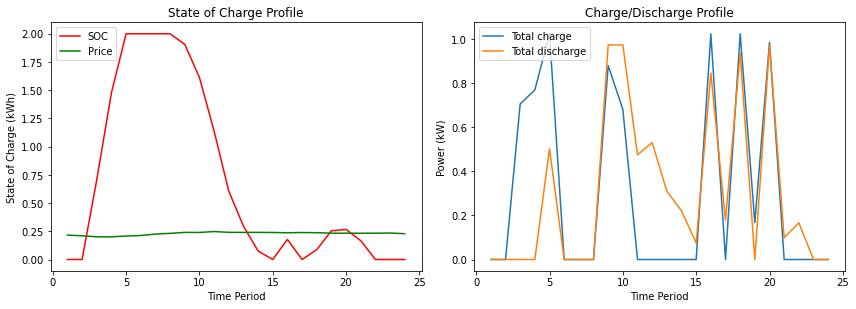

In [42]:
import matplotlib.pyplot as plt

# Extract variable values
PV_values = [pyo.value(model.PV_grid[t] + model.PV_load[t] + model.charge_PV[t]) for t in model.periods]
charge_values = [pyo.value(model.charge_PV[t] + model.charge_grid[t]) for t in model.periods]
disc_values = [pyo.value(model.disch_load[t] + model.disch_grid[t]) for t in model.periods]
load_values = [pyo.value(model.loads[t]) for t in model.periods]
SOC_values = [pyo.value(model.SOC[t]) for t in model.periods]
price_values=[pyo.value(model.sellP[t]) for t in model.periods]


# Create time periods
time_periods = list(model.periods)

# Create subplots for PV, charge, discharge, load, and SOC
plt.figure(figsize=(12, 8))

# Plot charge and discharge
plt.subplot(2, 2, 2)
plt.plot(time_periods, charge_values, label='Total charge')
plt.plot(time_periods, disc_values, label='Total discharge')
plt.xlabel('Time Period')
plt.ylabel('Power (kW)')
plt.legend(loc='upper left')
plt.title('Charge/Discharge Profile')

# Plot SOC
plt.subplot(2, 2, 1)
plt.plot(time_periods, SOC_values, label='SOC', color='r')
plt.plot(time_periods, price_values, label='Price', color='g')
plt.xlabel('Time Period')
plt.ylabel('State of Charge (kWh)')
plt.legend(loc='upper left')
plt.title('State of Charge Profile')


plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


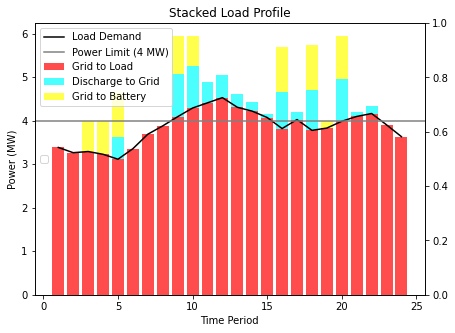

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values from the Pyomo model
pv_values = [model.PV_load[t]() for t in model.periods]
load_penalty_values = [model.grid[t]() for t in model.periods]
load_demand_values = [model.loads[t] for t in model.periods]
grid_charge_value = [model.charge_grid[t]() for t in model.periods]
grid_discharge_value = [model.disch_grid[t]() for t in model.periods]
#load_discharge_value = [model.disch_load[t]() for t in model.periods]
#def grid_rule(model,t):
#    return model.grid[t] + model.charge_grid[t] - model.PV_grid[t] - model.disch_grid[t] <= P_lim
#model.grid_constraint = pyo.Constraint(model.periods, rule=grid_rule)


# Calculate discharge values as the difference between load penalty and load demand
discharge_values = [model.disch_load[t]() for t in model.periods]

# Create an array for the time periods
time_periods = list(model.periods)

# Create a stacked bar chart
fig, ax1= plt.subplots(figsize=(7, 5))

# Plot the load penalty
ax1.bar(time_periods, load_penalty_values, label='Grid to Load', alpha=0.7, color='red')

# Plot the discharge power
#ax1.bar(time_periods, discharge_values, label='Discharge to Load', alpha=0.7, color='green')

# Plot the discharge power
ax1.bar(time_periods, grid_discharge_value, bottom=np.array(load_penalty_values), label='Discharge to Grid', alpha=0.7, color='cyan')

# Plot the charge power
ax1.bar(time_periods, grid_charge_value, bottom=np.array(load_penalty_values) + np.array(grid_discharge_value), label='Grid to Battery', alpha=0.7, color='yellow')

# Plot the load demand as a curve
ax1.plot(time_periods, load_demand_values, label='Load Demand', color='black')

# PLot the grid's power limit
ax1.axhline(y=P_lim, color='grey', linestyle='-', label='Power Limit (4 MW)')

ax2=ax1.twinx()
ax2.legend(loc='center left')

# Set labels and legend
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Power (MW)')
ax1.set_title('Stacked Load Profile')
ax1.legend()

# Show the plot
plt.show()

In [44]:
## SCRAP:

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1+ 0.03) ** year
    print()
    print()
    print("-------------------------------------------------------------------")
    print("Solving for year", year, "with a scaling factor of", yearly_scaling_factor)
    print("-------------------------------------------------------------------")
    print()
    print()

    #Environment
    model = pyo.ConcreteModel()

    #Sets
    model.periods = pyo.Set(initialize=range(1,25,1))   #indexed by "t" for time step

    # Scale the load time series for this year
    load1 = [x * yearly_scaling_factor for x in load_time_series_subset.sum(axis=1).tolist()]
    loads_data = {t: load1[t-1] for t in model.periods}
    loads_data[24] = 4
    sellP_data = {t: sellPrice[t] for t in model.periods}
    buyP_data = {t: buyPrice[t] for t in model.periods}

    #Parameters
    model.loads = pyo.Param(model.periods, initialize=loads_data)     #load demand
    model.sellP = pyo.Param(model.periods,initialize=sellP_data)  #price to discharge
    model.buyP = pyo.Param(model.periods,initialize=buyP_data)    #price to charge
    model.PV = pyo.Param(model.periods,initialize=0)           #determinsitic solar power production
    model.SOC_0 = pyo.Param(model.periods,initialize=0)   #initial state of charge of battery
    model.penalty_cost = pyo.Param(model.periods,initialize=10)  #penalty for not covering load demand (arbitrary, used as slack variable)

    #Variables:
    model.charge = pyo.Var(model.periods, bounds=(0, charging_power_limit))       #assuming no discharge in first hour
    model.disch = pyo.Var(model.periods, bounds=(0, discharging_power_limit))  #assuming full discahrge to meet load in first hour
    model.grid = pyo.Var(model.periods, within=NonNegativeReals)   #power bought from market
    model.charge_PV = pyo.Var(model.periods, within=NonNegativeReals) #Charge from PV 
    model.charge_grid = pyo.Var(model.periods, within=NonNegativeReals) #Charge bought from grid
    model.disch_grid = pyo.Var(model.periods, within=NonNegativeReals)  #Discharged power to grid
    model.disch_load = pyo.Var(model.periods, within=NonNegativeReals)  #Discharged power to load
    model.PV_load = pyo.Var(model.periods, within=NonNegativeReals)     #PV power to load 
    model.PV_grid  = pyo.Var(model.periods, within=NonNegativeReals)    #PV power sold to grid           


    #Constraints
    def charge_rule(model, t):
        return (model.charge_PV[t]+ model.charge_grid[t])*charging_efficiency  == model.charge[t]
    model.charge_constraint = pyo.Constraint(model.periods, rule=charge_rule)

    def disch_rule(model,t):
        return (model.disch_grid[t] + model.disch_load[t])/discharging_efficiency == model.disch[t] 
    model.disch_constraint = pyo.Constraint(model.periods, rule=disch_rule)

    def PV_rule(model,t):
        return model.PV_load[t] + model.PV_grid[t] + model.charge_PV[t] == model.PV[t]
        #return model.PV_load[t] + model.PV_grid[t]  == model.PV[t]
    model.PV_constraint = pyo.Constraint(model.periods, rule=PV_rule)

    def load_rule(model, t):
        return model.PV_load[t] + model.disch_load[t]+ model.grid[t] == model.loads[t]
        #return model.PV_load[t] + model.grid[t] == model.loads[t]
    model.load_constraint = pyo.Constraint(model.periods, rule=load_rule)

    def SOC_limit(model, t):
        return (0,capacity)
    model.SOC = pyo.Var(model.periods,bounds=SOC_limit)

    #NEW CONSTRAINT LIMITING NET POWER IMPORT FORM THE GRID TO THE SYSTEM SPECIFIC FOR TASK 4
    def grid_rule(model,t):
        return model.grid[t] + model.charge_grid[t] - model.PV_grid[t] - model.disch_grid[t] <= P_lim
    model.grid_constraint = pyo.Constraint(model.periods, rule=grid_rule)

    #def SOC_end(model,t):
    #    tolerance = 1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    #    return model.SOC[t, max(model.periods)] >= capacity - tolerance

    def state_of_charge(model, t):  
        if t == 1:
            return model.SOC[t] == model.SOC_0[t] + model.charge_PV[t] + model.charge_grid[t] - (model.disch_grid[t] + model.disch_load[t])
        elif 1<t<24:  
            return model.SOC[t] == model.SOC[t-1] + model.charge_PV[t] + model.charge_grid[t] - (model.disch_grid[t] + model.disch_load[t])
        else:
            return model.SOC[t] - (model.SOC[t-1]  + model.charge_PV[t] + model.charge_grid[t] - (model.disch_grid[t] + model.disch_load[t]))==0
    model.state_of_charge_constraint = pyo.Constraint(model.periods, rule=state_of_charge)

    #Objective function to minimize costs
    def objective_rule(model):
        return sum((model.charge_grid[t] + model.grid[t])*model.buyP[t]*1 for t in model.periods) - sum((model.PV_grid[t] + model.disch_grid[t])*1*model.sellP[t] for t in model.periods)
        #return sum(( model.grid[t])*model.buyP[t] for t in model.periods) - sum((model.PV_grid[t])*model.sellP[t] for t in model.periods)
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    #solving
    solver = SolverFactory('gurobi')
    results = solver.solve(model, tee=True)
    #results = opt.solve(model, tee=True)
    model.display()
    #model.pprint()
    #model.Constraint.pprint()
    print("Objective Value:", model.objective())



-------------------------------------------------------------------
Solving for year 0 with a scaling factor of 1.0
-------------------------------------------------------------------




Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03
Read LP format model from file C:\Users\benny\AppData\Local\Temp\tmplncd6t82.pyomo.lp
Reading time = 0.01 seconds
x1: 144 rows, 240 columns, 527 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 240 columns and 527 nonzeros
Model fingerprint: 0xcba27850
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [1e+00, 2e+00]
  RHS range        [3e+00, 4e+00]
Presolve removed 120 rows and 192 columns
Presolve time: 0.00s
Presolved: 24 rows, 48 columns, 71 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3429177e+01   2.067250e+02   0.000000e+00      0s
Extra simplex iterations after uncrush: 3
      

ValueError: No value for uninitialized NumericValue object charge_grid[1]